# Reinforcement Learning

**Goal:** Model the Emotion Task behavioral data using Q-Learning<br>
**Date:** June - July 2023


***
## Simulate behavioral task

### Two Possible Trial Types
**Reinforcement Trials**
- 1 fractal presented with central fixation point
- Monkey must hold fixation until Delay Period, after which he receives outcome
- Reinforcement only (no choice)

<img src="../imgs/reinforcement_trial.png" width="400"> <br>

**Choice Trials**
- 2 fractals presented simultaneously
- Monkey must hold fixation until Choice Period, followed by Delay Period, after which he receives outcome for chosen fractal

<img src="../imgs/choice_trial.png" width="400">

### To Do:
**Update Action Policy**
- attempt 1: only update Q for chosen action
- attempt 2: update Q for chosen action, update Q for not-chosen action with small decay (i.e. gamma)
**Multiply Learning Rates**
- Potentially add alpha for large vs. small 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# custom functions
from rl_utils import select_session
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')

***
## Import Session

#### Select session to model

In [2]:
from rl_utils import select_session
# Set paths
ROOT = '/Users/rahimhashim/Google Drive/My Drive/Columbia/Salzman/Monkey-Training/'
VIDEO_ROOT = os.path.join(ROOT, 'tasks', 'rhAirpuff', '8. Probabilistic_Reward_Airpuff_Choice', 'videos')
SESSION_ROOT = os.path.join(ROOT, 'data', 'processed', 'processed_Probabilistic_Reward_Airpuff_Choice')

# Select session
DATE = '230705'
MONKEY = 'Aragorn'

session_df = select_session(SESSION_ROOT, DATE, MONKEY, correct_only=False)
# exclude neutral fractals
# session_df = session_df[(session_df['valence_1'] != 0) & (session_df['valence_2'] != 0)]
session_df['block_change'] = session_df['block'].diff().fillna(0)
session_df_correct = session_df[session_df['correct'] == 1]
session_df_choice = session_df_correct[session_df_correct['choice_trial'] == 1]

# Show relevant columns from session
pd.set_option('display.max_rows', 20)
session_df_correct[['choice_trial', 'stimuli_name_1', 'stimuli_name_2', 'fractal_chosen', 'valence']]

Selecting session: 230705_Aragorn


,choice_trial,stimuli_name_1,stimuli_name_2,fractal_chosen,valence
0,0,_fractal_C,_fractal_C,_fractal_C,0.0
2,1,_fractal_A,_fractal_E,_fractal_E,-1.0
3,1,_fractal_A,_fractal_B,_fractal_B,0.5
4,0,_fractal_D,_fractal_D,_fractal_D,-0.5
6,0,_fractal_A,_fractal_A,_fractal_A,1.0
...,...,...,...,...,...
632,0,_fractal_A,_fractal_A,_fractal_A,-0.5
633,1,_fractal_C,_fractal_E,_fractal_E,0.5
634,1,_fractal_A,_fractal_E,_fractal_E,0.5
640,0,_fractal_C,_fractal_C,_fractal_C,0.0


In [100]:
# look at these fractal comparisons
fractals_selected = ['_fractal_B', '_fractal_C']

# select only trials in block 1 with _fractal D or E as stimuli
session_df_choice_DE = session_df_choice[(session_df_choice['block'] == 2) & 
                                         (session_df_choice['stimuli_name_1'].isin(fractals_selected)) & 
                                         (session_df_choice['stimuli_name_2'].isin(fractals_selected))]
session_df_choice_DE[['choice_trial', 'stimuli_name_1', 'stimuli_name_2', 'fractal_chosen', 'valence']]

,choice_trial,stimuli_name_1,stimuli_name_2,fractal_chosen,valence
276,1,_fractal_B,_fractal_C,_fractal_B,-1.0
291,1,_fractal_B,_fractal_C,_fractal_C,0.0
441,1,_fractal_C,_fractal_B,_fractal_B,-1.0
518,1,_fractal_C,_fractal_B,_fractal_B,-1.0
629,1,_fractal_B,_fractal_C,_fractal_B,-1.0


## Assign Reward Outcomes

### 5 states with pre-assigned reward outcomes

| State   | Outcome (Pre-) | Outcome (Post-)|
|  :---        |    :----:      |         :---:  |
| __fractal_A_ |       2        |      -1        |
| __fractal_B_ |       1        |      -2        |
| __fractal_C_ |       0        |       0        |
| __fractal_D_ |       -1       |       2        |
| __fractal_E_ |       -2       |       1        |

In [4]:
# 5 Fractals
cs_list = ['_fractal_A', '_fractal_B', '_fractal_C', '_fractal_D', '_fractal_E']
r_table_preswitch = {'_fractal_A': 2, '_fractal_B': 1, '_fractal_C': 0, '_fractal_D': -1, '_fractal_E': -2}
p_r_table_preswitch = {'_fractal_A': 1, '_fractal_B': 1, '_fractal_C': 1, '_fractal_D': 0.5, '_fractal_E': 1}
r_table_postswitch = {'_fractal_A': -1, '_fractal_B': -2, '_fractal_C': 0, '_fractal_D': 2, '_fractal_E': 1}
p_r_table_postswitch = {'_fractal_A': 0.5, '_fractal_B': 1, '_fractal_C': 1, '_fractal_D': 1, '_fractal_E': 1}


# # 4 Fractals
# cs_list = ['_fractal_A', '_fractal_B', '_fractal_D', '_fractal_E']
# r_table_preswitch = {'_fractal_A': 2, '_fractal_B': 1, '_fractal_D': -1, '_fractal_E': -1}
# p_r_table_preswitch = {'_fractal_A': 1, '_fractal_B': 1, '_fractal_D': 1, '_fractal_E': 0.5}
# r_table_postswitch = {'_fractal_A': -1, '_fractal_B': -2, '_fractal_D': 1, '_fractal_E': 2}
# p_r_table_postswitch = {'_fractal_A': 0.5, '_fractal_B': 1, '_fractal_D': 1, '_fractal_E': 1}

import seaborn as sns
# get values from jet colormap
cmap = plt.cm.jet_r
# colors = cmap(np.linspace(0, 1, len(set(cs_list))))
# get 5 colors from tab10
colors = sns.color_palette('colorblind', n_colors=len(cs_list))
color_keys = sorted(set(cs_list), reverse=True)
color_dict = dict(zip(color_keys, colors))


# try alpha values from 0.1 to 1.0
alpha_list = np.arange(0.1, 1.1, 0.1)
# try beta values from -10 to 10
beta_list = np.arange(-10, 11, 1)
# try lamda values from 0.5 to 1.0
lamda_list = sorted(np.append(np.linspace(0.1, 1, 10), np.arange(0.92, 1, 0.02)), reverse=False)

## Q-Learning Model

### I. Simulate two-choise task data with 5 states based on RL updating rule 

Q-Learning Equation
## $$Q_{new}(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(R+ \gamma\max_aQ(s_{t+1}, a) - Q(s_t, a_t))$$

Modified for Task

## $$Q_{new}(s_i,a_i) \leftarrow Q(s_i,a_i) + \alpha(R - Q(s_t, a_t))$$

## $$Q_{new}(s_i) \leftarrow \gamma Q(s_t)$$

### A two-choice decision making task

### 1. The reward is given based on $p$, with 5 possible magnitudes
$p$: The probability of getting a reward<br>
$m$: The magnitude of reward ([2, 1, 0, -1, -2])

### 2. Action-State value $Q(s,a)$ update: Q-learning


#### 2.1. Define the states: 
  There are four states $s_0$ for this task. All you need to make a decision no matter what timestep you are. 

 So you only need to know: $Q(s=s_0, a)$

####  $$Q(s_0,a_t) \leftarrow Q(s_0,a_t) + \alpha(R  - Q(s_0, a_0))$$

#### 2.2. Action-selection policy 
There are two possible actions: choose large or choose small

Given the $Q$-value ($Q(s,a)$), you need to choose a action $a_i$ based on Softmax function: 

#### $$P(a_i| s_i) = \frac{\beta\exp(Q(a_i,s_i))}{\sum_j \exp( \beta Q(a_j,s_))}$$


### 3. The data should include States and actions
We want the states, actions during the learning process, which is similar as the $Q$-value update process. 

In [5]:
import random
from scipy import optimize
import threading
from collections import defaultdict
# turn off RuntimeWarning: overflow encountered in exp
np.seterr(over='ignore')
import warnings
# turn off RuntimeWarning: invalid value encountered in scalar divide
warnings.filterwarnings("ignore", category=RuntimeWarning)

def generate_data(cs_list, n=100, verbose=True):

  cs_pairs_list = []
  for i in np.arange(n): # for n-steps learning(q-value updating)
    # Probability of choice trial
    choice_trial = random.random() < 0.25
    # Choice Trial -- 2 CS, choose 1
    if choice_trial:
      # Randomly select 2 CS from cs_list
      cs_pair = np.random.choice(cs_list, 2, replace=False)
      cs_pairs_list.append(cs_pair)
    else:
      # Reinforcement trial -- 1 CS, forced choice
      cs_pair = np.random.choice(cs_list, 1)[0]
      cs_pairs_list.append([cs_pair, np.nan])
  return cs_pairs_list

def simulate_model(cs_list, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda=None, repetition=10, verbose=True):
  # array of actions, action probability, and rewards
  actions = []
  action_prob = []
  rewards = []
  # number of trials
  n = len(cs_pairs_list)
  # create a table store the update process of q-value, which has two actions, four states.
  Qs = defaultdict(list)
  for cs in cs_list:
    Qs[cs] = np.zeros(n)
  # Print parameters
  if verbose:
    print(f'   alpha: {round(alpha, 2)}, beta: {round(beta, 2)}, lambda: {round(lamda, 2)}, repetition: {repetition}')
  for i in np.arange(1, n): # for n-steps learning(q-value updating)
    # Get CS pair
    cs_pair = cs_pairs_list[i-1]
    if choice_trials[i-1] == 1:
      # Get Q-values for each CS
      Q_1 = Qs[cs_pair[0]][i-1]
      Q_2 = Qs[cs_pair[1]][i-1]
      # Calculate probability of choosing each CS
      prob_a_q1 = np.exp(beta*Q_1)/(np.sum(np.exp(beta*Q_1 + np.exp(beta*Q_2))))
      prob_a_q2 = np.exp(beta*Q_2)/(np.sum(np.exp(beta*Q_1 + np.exp(beta*Q_2))))
      # Simulate choice based on prob_a
      choice = random.random()
      if choice < prob_a_q1:
        a = cs_pair[0]
        Q = Q_1
      else:
        a = cs_pair[1]  
        Q = Q_2
      action_prob.append(prob_a_q1)
    # Reinforcement trial -- 1 CS, forced choice
    else:
      a = cs_pair[0]
      Q = Qs[a][i-1]
      action_prob.append(np.nan)
    # calculate reward for action based on r_table
    p_r = random.random()
    if i < switch_trial:
      r_table = r_table_preswitch
      p_r_table = p_r_table_preswitch
    else:
      r_table = r_table_postswitch
      p_r_table = p_r_table_postswitch
    # Simulate reward based on p_r, and action
    if p_r < p_r_table[a]:
        r = r_table[a]
    else:
      r = 0
    # Update Q table for chosen action
    Qs[a][i] = Q + alpha * (r - Q)
    # Update values for all non-chosen actions
    for cs in cs_list:
      if cs != a:
        # No forgetting rate
        if lamda is None:
          Qs[cs][i] = Qs[cs][i-1]
        # With forgetting rate
        else:
          Qs[cs][i] = Qs[cs][i-1] * lamda
    # Store values
    actions.append(a)
    rewards.append(r)
  return cs_pairs_list, actions, action_prob, rewards, Qs

def evaluate_model(choice_trials, actions_real, actions_model, switch_trial):
  # evaluate the performance of the model
  if actions_real:
    actions_model = actions_model + [0]
    actions_real_choice = [actions_real[i] for i in range(len(actions_real)) if choice_trials[i] == 1]
    actions_model_choice = [actions_model[i] for i in range(len(actions_model)) if choice_trials[i] == 1]
    # only evaluate trials after fractal has been seen 3+ times pre- and post- switch
    actions_real_choice = actions_real_choice[3:switch_trial] + actions_real_choice[switch_trial+3:]
    actions_model_choice = actions_model_choice[3:switch_trial] + actions_model_choice[switch_trial+3:]
    performance_model = [1 if actions_model_choice[i]  == actions_real_choice[i] else 0 for i in range(len(actions_real_choice))]
    performance = np.sum(performance_model)/len(performance_model)
    print(f'\tperformance: {np.round(performance, 3)}')
  else:
    performance = np.nan
  return performance

# thread process to run the simulation
def run_simulation_parallel(paramter_df, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda, repetition):
  cs_pairs_list, actions, action_prob, rewards, Qs = \
          simulate_model(cs_list, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda, repetition, verbose=True)
  paramter_df.loc[len(paramter_df)] = [alpha, beta, lamda, cs_pairs_list, actions, action_prob, rewards, Qs]

def run_simulation_sequential(cs_list, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda, repetition, verbose=True):
  cs_pairs_list, actions, action_prob, rewards, Qs = \
          simulate_model(cs_list, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda, repetition, verbose=True)
  return cs_pairs_list, actions, action_prob, rewards, Qs

def parameter_grid_search(cs_pairs_list, actions_real, switch_trial, repetitions=100, threading_flag=True):
  print('  Simulating model...')

  # create a dataframe to store the results
  parameter_df = pd.DataFrame(columns=['alpha', 'beta', 'lamda', 'repetition', 'performance', 'cs_pairs_list', 'actions', 'action_prob', 'rewards', 'Qs'])
  
  # choice trial if cs_pair_list[i][1] is not a float (i.e. np.nan))
  choice_trials = [1 if (type(cs_pair[1]) != float) else 0 for cs_pair in cs_pairs_list]

  threads = []
  # run the simulation for each parameter combination
  for alpha in alpha_list:
    for beta in beta_list:
      for lamda in lamda_list:
          for repetition in range(repetitions):
            if threading_flag == True:
              thread = threading.Thread(target=run_simulation_parallel, 
                                        args=(parameter_df, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda, repetition))
              threads += [thread]
              thread.start()
            else:
              cs_pairs_list, actions_model, action_prob, rewards, Qs = \
                simulate_model(cs_list, cs_pairs_list, choice_trials, switch_trial, alpha, beta, lamda, repetition, verbose=True)
              # evaluate the performance of the model
              performance = evaluate_model(choice_trials, actions_real, actions_model, switch_trial)
              parameter_df.loc[len(parameter_df)] = [alpha, beta, lamda, repetition, performance, cs_pairs_list, actions_model, action_prob, rewards, Qs]
  for thread in threads:
    thread.join()  # makes sure that the main program waits until all threads have terminated

  print('  Simulation complete.')

  return parameter_df

def run_q_model():

  print(f'Running Q-learning model...')
  # check to see if cs_pairs_list variable exists in workspace
  try:
    cs_1_list = session_df_correct['stimuli_name_1'].tolist()
    cs_2_list = session_df_correct['stimuli_name_2'].tolist()
    # replace cs_2 with np.nan if cs_1 == cs_2
    cs_2_list = [np.nan if cs_1_list[i] == cs_2_list[i] else cs_2_list[i] for i in range(len(cs_1_list))]
    cs_pairs_list = list(zip(cs_1_list, cs_2_list))
    actions = session_df_correct['fractal_chosen'].tolist()
    num_trials = len(cs_pairs_list)
    switch_trial = np.diff(session_df_correct['block'].values).nonzero()[0][0]
    print(f'  Using session {DATE} {MONKEY}...')
    print(f'   num_trials: {num_trials}, switch_trial: {switch_trial}')
  except:
    print('No cs_pairs_list found, randomizing new cs_pairs_list...')
    n = 100
    switch_trial = 49
    cs_pairs_list = generate_data(cs_list, n=n, verbose=True)
    actions = None

  # run the grid search
  parameter_df = parameter_grid_search(cs_pairs_list, actions, switch_trial, repetitions=10, threading_flag=False)
  # sort by alpha, then beta, then lamda, in reverse order
  parameter_df = parameter_df.sort_values(by=['alpha', 'beta', 'lamda'], ascending=False, ignore_index=True)
  print('Q-learning model complete!')

  return parameter_df

parameter_df = run_q_model()
# # evaluate the performance of the model
# parameter_estimate = parameter_df.actions.tolist()[0] + [0]
# performance_model = [1 if parameter_estimate[i]  == actions[i] else 0 for i in range(len(actions))]
# print(f'Performance: {np.sum(performance_model)/len(performance_model)}')

Running Q-learning model...
  Using session 230705 Aragorn...
   num_trials: 393, switch_trial: 199
  Simulating model...
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 0
	performance: 0.505
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 1
	performance: 0.431
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 2
	performance: 0.505
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 3
	performance: 0.486
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 4
	performance: 0.459
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 5
	performance: 0.532
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 6
	performance: 0.514
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 7
	performance: 0.431
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 8
	performance: 0.523
   alpha: 0.1, beta: -10, lambda: 0.1, repetition: 9
	performance: 0.431
   alpha: 0.1, beta: -10, lambda: 0.2, repetition: 0
	performance: 0.505
   alpha: 0.1, beta: -10, lambda: 0.2, repetition: 1
	performance: 0.44
   

In [6]:
pd.set_option('display.max_rows', 20)
# get mean performance for each parameter combination
parameter_df.sort_values(by=['performance'], ascending=False, ignore_index=True)

,alpha,beta,lamda,repetition,performance,cs_pairs_list,actions,action_prob,rewards,Qs
0,0.9,3,0.98,2,0.770642,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_B, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 1, 0, 2, -2, -2, 1, -1, 0, 2, 1, 0, 0,...","{'_fractal_A': [0.0, 0.0, 0.0, 0.0, 0.0, 1.8, ..."
1,0.6,3,0.96,3,0.761468,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_A, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 2, -1, 2, -2, -2, 1, 0, -1, 2, 1, -1, ...","{'_fractal_A': [0.0, 0.0, 0.0, 1.2, 1.15200000..."
2,0.8,6,0.80,2,0.761468,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_B, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 1, -1, 2, -2, -2, 1, 0, -1, 2, 1, -1, ...","{'_fractal_A': [0.0, 0.0, 0.0, 0.0, 0.0, 1.6, ..."
3,0.3,5,0.96,3,0.761468,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_A, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 2, 0, 2, -2, -2, 1, -1, -2, 2, 1, -1, ...","{'_fractal_A': [0.0, 0.0, 0.0, 0.6000000000000..."
4,0.1,6,0.96,7,0.761468,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_B, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 1, 0, 2, -2, -2, 1, 0, 0, 2, 1, 0, 0, ...","{'_fractal_A': [0.0, 0.0, 0.0, 0.0, 0.0, 0.2, ..."
...,...,...,...,...,...,...,...,...,...,...
29395,0.7,-4,0.98,3,0.229358,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_A, _fractal_A, _fractal_...","[nan, 0.36787944117144233, 0.3678794411714424,...","[0, 2, 2, -1, 2, -2, -2, 1, -1, -1, 2, 1, 0, 0...","{'_fractal_A': [0.0, 0.0, 1.4000000000000001, ..."
29396,0.5,-3,0.92,5,0.229358,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_A, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 2, -1, 2, -2, -2, 1, -1, 0, 2, 1, -1, ...","{'_fractal_A': [0.0, 0.0, 0.0, 1.0, 0.92, 1.46..."
29397,0.2,-6,0.94,8,0.229358,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_A, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 2, -1, 2, -2, -2, 1, -1, -1, 2, 1, 0, ...","{'_fractal_A': [0.0, 0.0, 0.0, 0.4, 0.37600000..."
29398,0.5,-10,0.80,3,0.229358,"[(_fractal_C, nan), (_fractal_A, _fractal_E), ...","[_fractal_C, _fractal_E, _fractal_A, _fractal_...","[nan, 0.36787944117144233, 0.36787944117144233...","[0, -2, 2, 0, 2, -2, -2, 1, 0, -2, 2, 1, -1, 0...","{'_fractal_A': [0.0, 0.0, 0.0, 1.0, 0.8, 1.4, ..."


Max performance: 0.7257425742574257
  alpha: 0.1,          beta: 10,          lamda: 0.9600000000000001


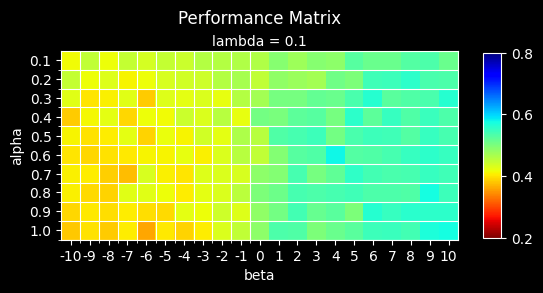

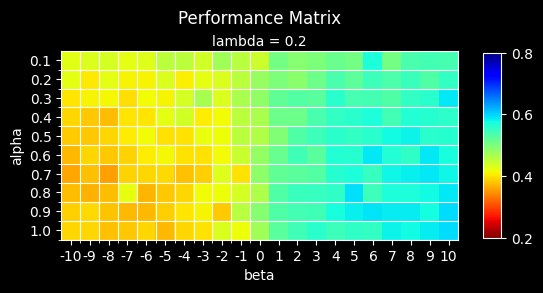

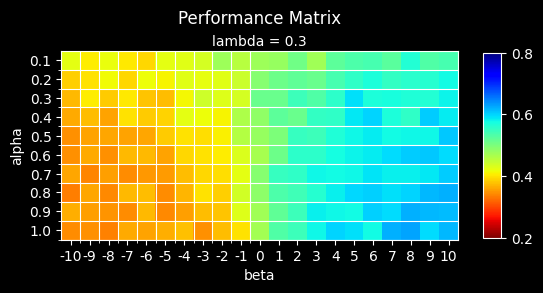

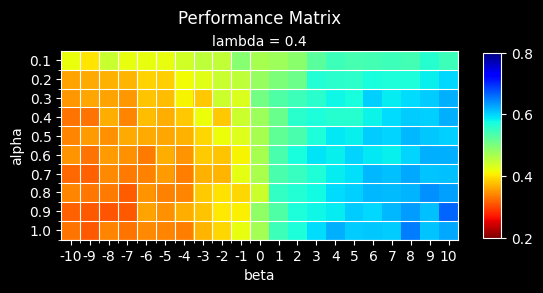

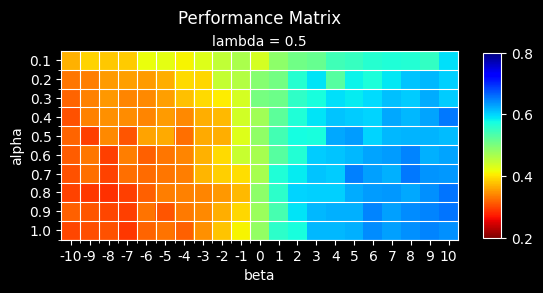

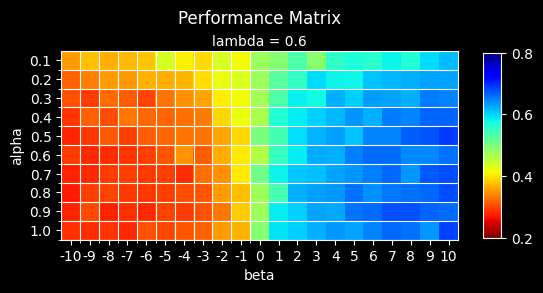

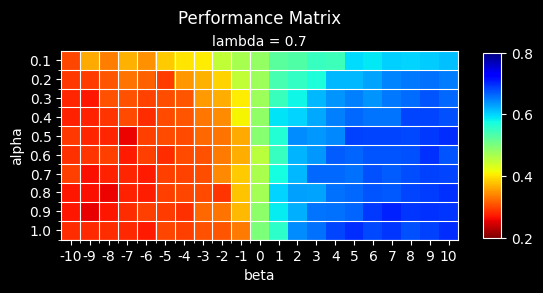

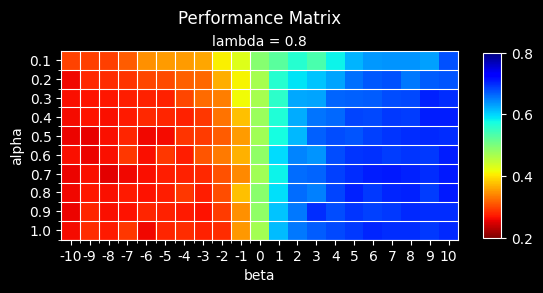

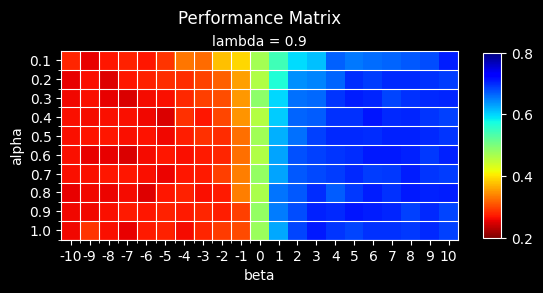

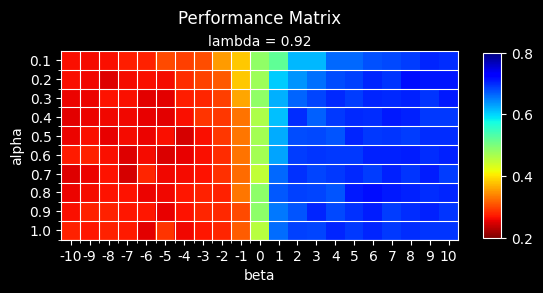

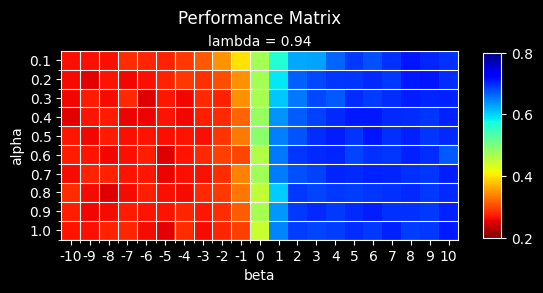

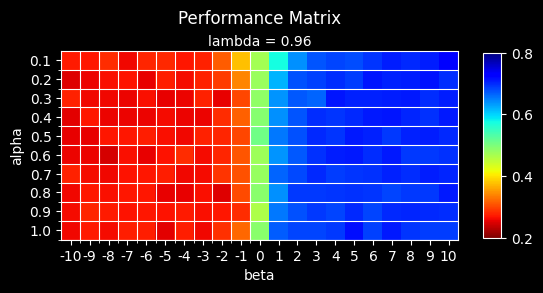

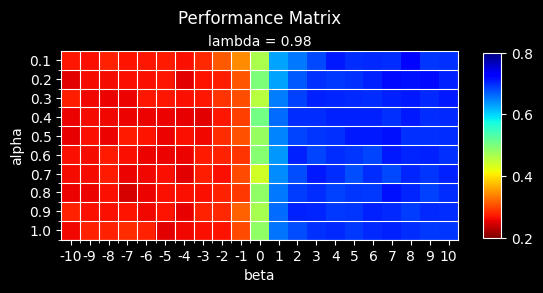

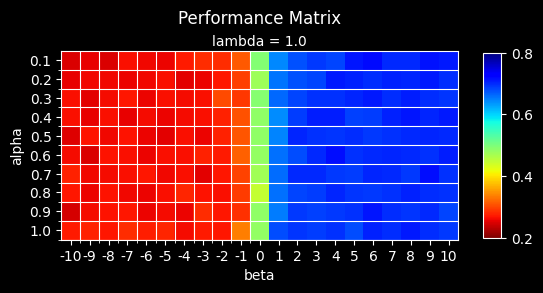

In [44]:
from matplotlib.ticker import AutoMinorLocator

performance_matrix = np.zeros((len(alpha_list), len(beta_list), len(lamda_list)))
# max performance dictionary
max_perf_dict = {'alpha': 0, 'beta': 0, 'lamda': 0, 'performance': 0}
# calculate mean performance for each parameter combination
for i, alpha in enumerate(alpha_list):
  for j, beta in enumerate(beta_list):
    for k, lamda in enumerate(lamda_list):
      performance_matrix[i][j][k] = parameter_df[(parameter_df['alpha'] == alpha) & \
                                                 (parameter_df['beta'] == beta) & \
                                                 (parameter_df['lamda'] == lamda)]['performance'].mean()
      # find max performance
      if performance_matrix[i][j][k] > max_perf_dict['performance']:
        max_perf_dict['alpha'] = alpha
        max_perf_dict['beta'] = beta
        max_perf_dict['lamda'] = lamda
        max_perf_dict['performance'] = performance_matrix[i][j][k]

# Print max performance

print('Max performance: {}'.format(max_perf_dict['performance']))
print('  alpha: {}, \
         beta: {}, \
         lamda: {}'.format(max_perf_dict['alpha'], max_perf_dict['beta'], max_perf_dict['lamda']))

# blue to red colormap
for lamda in range(len(lamda_list)):
  # Plot performance matrix
  fig, ax = plt.subplots()
  im = ax.imshow(performance_matrix[:, :, lamda], cmap='jet_r', interpolation='nearest')
  ax.set_xticks(np.arange(len(beta_list)))
  ax.set_yticks(np.arange(len(alpha_list)))
  # round to 1 decimal place
  beta_list = [round(beta, 1) for beta in beta_list]
  alpha_list = [round(alpha, 1) for alpha in alpha_list]
  ax.set_xticklabels(beta_list)
  ax.set_yticklabels(alpha_list)
  ax.set_xlabel('beta')
  ax.set_ylabel('alpha')
  ax.text(0.5, 1.05, f'lambda = {round(lamda_list[lamda], 2)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
  # set title above the text
  ax.set_title('Performance Matrix', y=1.1)
  # set colorbar from 0.4 to 0.7
  im.set_clim(0.2, 0.8)
  # Create colorbar with size and position relative to axes
  cbar = ax.figure.colorbar(im, ax=ax, shrink=0.5, aspect=10)
  # grid lines right aligned
  minor_locator = AutoMinorLocator(2)
  plt.gca().xaxis.set_minor_locator(minor_locator)
  plt.gca().yaxis.set_minor_locator(minor_locator)
  plt.grid(which='minor')
  # turn off major grid
  plt.grid(which='major', alpha=0)
  # save to cwd
  plt_title = f'perf{lamda}.png'
  plt.savefig(plt_title, dpi=300, bbox_inches='tight', pad_inches = 0.1)  


In [62]:
import imageio
def gif_generator():
  image_dir = os.path.join(os.getcwd(), 'perf')
  # sort by number in name
  image_png = [image for image in os.listdir(image_dir) if image.endswith('.png')]
  image_num = sorted([int(image.split('.')[0][4:]) for image in image_png], reverse=False)
  images = [f'perf{num}.png' for num in image_num]
  with imageio.get_writer(os.path.join(image_dir, 'perf_vid.gif'), mode='I', duration=0.1) as writer:
      for filename in images:
          image = imageio.imread(filename)
          writer.append_data(image)

gif_generator()

/var/folders/8z/8tf_3z4d0_1cgj07xk0dtqq00000gn/T/ipykernel_61564/3967820667.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


***
## Plot Results

Performance: 0.7227722772277227


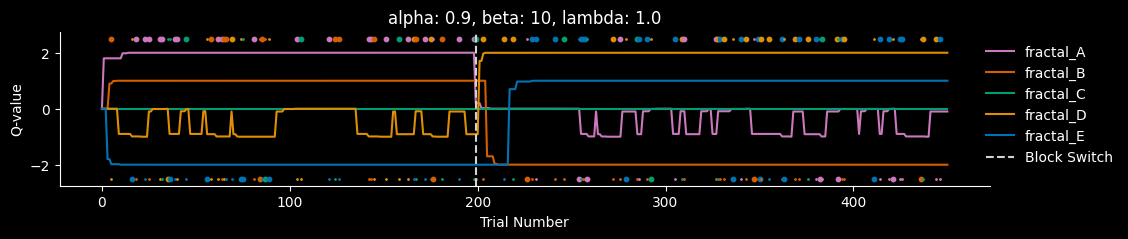

In [87]:
def plot_session(**kwargs):
  cs_pairs_list = kwargs['cs_pairs_list']
  actions = kwargs['actions']
  Qs = kwargs['Qs']
  alpha = kwargs['alpha']
  beta = kwargs['beta']
  lamda = kwargs['lamda']
  switch_trial = kwargs['switch_trial']
  choice_trials = kwargs['choice_trials']

  f, ax = plt.subplots(figsize=(12,2))
  
  # plot Qs for each cs
  for cs in Qs.keys():
    plt.plot(Qs[cs], color=color_dict[cs], label=cs[1:])

  # get max abs value of Qs
  max_abs = np.max(np.abs([Qs[cs] for cs in Qs.keys()])) + 0.5

  # size of chosen scatter
  s_chosen = 10
  s_not_chosen = 1

  # plot scatter of each trial cs pair and action
  for i in range(len(cs_pairs_list)-1):
    cs_pair = cs_pairs_list[i]
    cs_1 = cs_pair[0]
    cs_2 = cs_pair[1]
    action = actions[i]
    if i < switch_trial:
      r_table = r_table_preswitch
    else:
      r_table = r_table_postswitch
    # reinforcement trial
    if cs_2 is np.nan:
        pass
    #   plt.scatter(i, max_abs, marker='o', color=color_dict[cs_1], s=s_chosen)
    # choice trial: cs_1 > cs_2
    elif r_table[cs_1] > r_table[cs_2]:
      if action == cs_1:
        s1 = s_chosen
        s2 = s_not_chosen
      else:
        s1 = s_not_chosen
        s2 = s_chosen
      plt.scatter(i, max_abs, marker='o', color=color_dict[cs_1], s=s1)
      plt.scatter(i, -1*max_abs, marker='o', color=color_dict[cs_2], s=s2)
    # choice trial: cs_2 > cs_1
    else:
      if action == cs_2:
        s2 = s_chosen
        s1 = s_not_chosen
      else:
        s2 = s_not_chosen
        s1 = s_chosen
      plt.scatter(i, max_abs, marker='o', color=color_dict[cs_2], s=s2)
      plt.scatter(i, -1*max_abs, marker='o', color=color_dict[cs_1], s=s1)

  plt.axvline(x=switch_trial, c='lightgrey', linestyle='--', label='Block Switch')
  plt.xlabel('Trial Number')
  plt.ylabel('Q-value')
  # turn off splines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # legend outside of plot with no borders
  # add legend for cs as empty plot
  plt.legend(bbox_to_anchor=(0.99, 0.95), loc='upper left', borderaxespad=0., frameon=False)
  # set title as alpha, beta, gamma
  plt.title(f'alpha: {alpha}, beta: {beta}, lambda: {round(lamda, 2)}')
  # turn off grid
  plt.grid(False)
  plt.show()

# parameter_df_selected = parameter_df[(parameter_df['alpha'] == max_perf_dict['alpha']) & \
#                                       (parameter_df['beta'] == max_perf_dict['beta']) & \
#                                       (parameter_df['lamda'] == max_perf_dict['lamda'])]

parameter_df_selected = parameter_df[(parameter_df['alpha'] == 0.9) & \
                                      (parameter_df['beta'] == 10) & \
                                      (parameter_df['lamda'] == 1)]

# get repetition with highest performance
simulation_df_selected = parameter_df_selected.sort_values(by=['performance'], ascending=False, ignore_index=True)

print(f'Performance: {simulation_df_selected["performance"][0]}')

cs_pairs_list = simulation_df_selected['cs_pairs_list'][0]
actions = simulation_df_selected['actions'][0]
Qs = simulation_df_selected['Qs'][0]
alpha = simulation_df_selected['alpha'][0]
beta = simulation_df_selected['beta'][0]
lamda = simulation_df_selected['lamda'][0]
switch_trial = np.diff(session_df_correct['block'].values).nonzero()[0][0]
choice_trials = [1 if (type(cs_pair[1]) != float) else 0 for cs_pair in cs_pairs_list]

kwargs = {'cs_pairs_list': cs_pairs_list, 
          'actions': actions, 
          'Qs': Qs, 
          'alpha': alpha, 
          'beta': beta, 
          'lamda': lamda, 
          'switch_trial': switch_trial,
          'choice_trials': choice_trials}

plot_session(**kwargs)

_fractal_A
  Lick x Q Correlation: 0.68355 (1.29e-15)
     Shuffle: -0.16523 (0.09370884646967048)
  Blink x Q Correlation: -0.42525 (6.7993601344096405e-06)
     Shuffle: 0.15164 (0.12437492520930601)
_fractal_B
  Lick x Q Correlation: 0.69201 (5.92e-14)
     Shuffle: -0.08371 (0.43544703572053933)
  Blink x Q Correlation: -0.31993 (0.002241059689618652)
     Shuffle: -0.0733 (0.494806517555259)
_fractal_C
  Lick x Q Correlation: nan (nan)
     Shuffle: nan (nan)
  Blink x Q Correlation: nan (nan)
     Shuffle: nan (nan)
_fractal_D
  Lick x Q Correlation: 0.78257 (1.02e-22)
     Shuffle: 0.04736 (0.6330579106722418)
  Blink x Q Correlation: -0.40912 (1.617497706406398e-05)
     Shuffle: -0.0764 (0.44079779987027784)
_fractal_E
  Lick x Q Correlation: 0.87621 (4.56e-35)
     Shuffle: -0.06766 (0.4886542920577354)
  Blink x Q Correlation: -0.35594 (0.00016814191153331269)
     Shuffle: 0.11605 (0.23390460900282128)


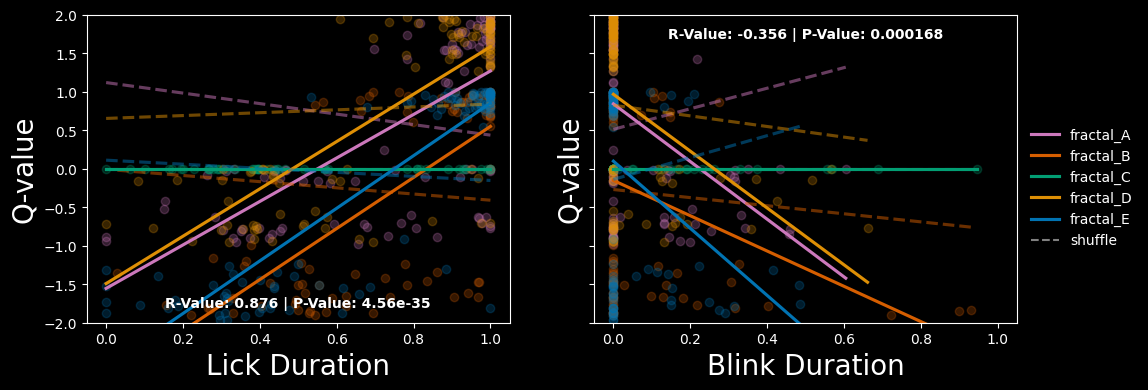

In [80]:
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, ttest_ind_from_stats, linregress
from matplotlib.offsetbox import AnchoredText

session_lick = session_df_correct['lick_duration'].tolist()
session_blick = session_df_correct['blink_duration_window'].tolist()
# calculate pearson correlation between lick duration and Q-value
f, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
for cs in Qs.keys():
	print(cs)
	# get trials only where cs is chosen
	fractal_lick = session_df_correct[session_df_correct['fractal_chosen'] == cs]['lick_duration'].tolist()
	fractal_blink = session_df_correct[session_df_correct['fractal_chosen'] == cs]['blink_duration_window'].tolist()
	Q = Qs[cs]
	Q = Q[~np.isnan(Q)]
	# get trials only where cs is chosen
	Q_fractal = Q[session_df_correct['fractal_chosen'] == cs]
	# LICK
	corr, p_val_lick = pearsonr(fractal_lick, Q_fractal)
	# get scientific notation for p-value
	p_val_lick = format(p_val_lick, '.3g')
	print(f'  Lick x Q Correlation: {round(corr, 5)} ({p_val_lick})')
	# shuffle Q_fractal
	Q_fractal_shuffle = Q_fractal.copy()
	np.random.shuffle(Q_fractal_shuffle)
	# calculate pearson correlation between lick duration and Q-value
	corr_shuffle, p_val_lick_shuffle = pearsonr(fractal_lick, Q_fractal_shuffle)
	print(f'     Shuffle: {round(corr_shuffle, 5)} ({p_val_lick_shuffle})')
	# plot scatter
	ax[0].scatter(fractal_lick, Q_fractal, color=color_dict[cs], alpha=0.25)
	sns.regplot(x=fractal_lick, y=Q_fractal, color=color_dict[cs], label=cs[1:], ax=ax[0], ci=None, scatter=False)
	sns.regplot(x=fractal_lick, y=Q_fractal_shuffle, color=color_dict[cs], ax=ax[0], 
	     ci=None, scatter=False, line_kws={'linestyle':'--', 'alpha': 0.5})
	# BLINK
	corr, p_val_blink = pearsonr(fractal_blink, Q_fractal)
	# get scientific notation for p-value
	p_val_lick = format(p_val_blink, '.3g')
	print(f'  Blink x Q Correlation: {round(corr, 5)} ({p_val_blink})')
	# calculate pearson correlation between lick duration and Q-value
	corr_shuffle, p_val_blink_shuffle = pearsonr(fractal_blink, Q_fractal_shuffle)
	print(f'     Shuffle: {round(corr_shuffle, 5)} ({p_val_blink_shuffle})')
	# plot scatter
	ax[1].scatter(fractal_blink, Q_fractal, color=color_dict[cs], alpha=0.25)
	sns.regplot(x=fractal_blink, y=Q_fractal, color=color_dict[cs], label=cs[1:], ax=ax[1], ci=None, scatter=False)
	sns.regplot(x=fractal_blink, y=Q_fractal_shuffle, color=color_dict[cs], ax=ax[1],
	     ci=None, scatter=False, line_kws={'linestyle':'--', 'alpha': 0.5})

plt.ylim([-2, 2])
# turn off grid
ax[0].grid(False)
ax[1].grid(False)
slope, intercept, r_value, p_value, std_err = linregress(fractal_lick, Q_fractal)
text = 'R-Value: {} | P-Value: {:.3g}'.format(round(r_value, 3), p_value)
# bold text
anchored_text = AnchoredText(text, loc='lower center',
															frameon=False, prop={'weight': 'bold'})
ax[0].add_artist(anchored_text)
ax[1].plot([], [], label='shuffle', linestyle='--', color='grey')
# legend outside of plot with no borders
ax[1].legend(bbox_to_anchor=(1.02, 0.5), loc='upper left', borderaxespad=0., frameon=False)
ax[0].set_xlabel('Lick Duration', fontsize=20)
ax[0].set_ylabel('Q-value', fontsize=20) 

slope, intercept, r_value, p_value, std_err = linregress(fractal_blink, Q_fractal)
text = 'R-Value: {} | P-Value: {:.3g}'.format(round(r_value, 3), p_value)
anchored_text = AnchoredText(text, loc='upper center',
														 frameon=False, prop={'weight': 'bold'})
ax[1].add_artist(anchored_text)
ax[1].set_xlabel('Blink Duration', fontsize=20)
ax[1].set_ylabel('Q-value', fontsize=20) 
	# corr, p_val_lick = pearsonr(session_lick, Q)
	# print(f'  Lick x Q Correlation: {round(corr, 5)} ({round(p_val_lick, 5)})')
	# corr, p_val_blick = pearsonr(session_blink, Q)
	# print(f'  Blink x Q Correlation: {round(corr, 5)} ({round(p_val_blick, 5)})')
plt.show()


In [ ]:
row_num = 20

# make table from one row of parameter_df
Qs_df = pd.DataFrame(parameter_df['Qs'][row_num])
cs_1_list = session_df_correct['stimuli_name_1'].tolist()
cs_2_list = session_df_correct['stimuli_name_2'].tolist()
# replace cs_2 with np.nan if cs_1 == cs_2
cs_2_list = [np.nan if cs_1_list[i] == cs_2_list[i] else cs_2_list[i] for i in range(len(cs_1_list))]
cs_pairs_list = list(zip(cs_1_list, cs_2_list))
Qs_df['choice_trials'] = [1 if (type(cs_pair[1]) != float) else 0 for cs_pair in cs_pairs_list]
Qs_df['cs_1'] = [cs_pairs_list[i][0] for i in range(len(cs_pairs_list))]
Qs_df['cs_2'] = [cs_pairs_list[i][1] for i in range(len(cs_pairs_list))]
Qs_df['action_sim'] = parameter_df['actions'][row_num] + [0]
Qs_df['action_real'] = session_df_correct['fractal_chosen'].values.tolist()
Qs_df['rewards'] = parameter_df['rewards'][row_num] + [0]
Qs_df['lick_duration'] = session_df_correct['lick_duration'].values.tolist()
Qs_df['blink_duration'] = session_df_correct['blink_duration_window'].values.tolist()

# turn off max rows
pd.set_option('display.max_rows', None)
Qs_df